In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, callbacks
from PIL import Image

In [2]:
classes = {1: 'Red Square', 2: 'Red Triangle', 3: 'Yellow Square', 4: 'Yellow Traingle'}
def generate():
    img = np.zeros((32, 32, 3), dtype=np.float)
    
    c = random.randint(1, 4) 
    
    size = random.randint(6, 15)
    pos_x = random.randint(0, 31 - size)
    pos_y = random.randint(0, 31 - size)
    img[pos_x:pos_x + size, pos_y:pos_y + size] = [255.0, 0.0, 0.0] if c < 3 else [255.0, 255.0, 0.0]
    if (c % 2 == 0):
        for i in range(size):
            for j in range(size):
                if i < j:
                    img[pos_x + i, pos_y + j] = [0, 0, 0]
            
    
    return img, float(size), float(pos_x), float(pos_y), c

In [3]:
def display(img):
    return Image.fromarray(img.astype(np.int8), mode='RGB')

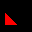

In [4]:
img, _, _, _, _ = generate()
display(img)

In [5]:
X = []
y = []
for i in range(10000):
    t = generate()
    X.append(t[0] / 255.0)
    y.append((t[1] / 32.0, t[2] / 32.0, t[3] / 32.0, int(t[4] == 1), int(t[4] == 2), int(t[4] == 3), int(t[4] == 4)))

In [60]:
def lc_model(conv_filters = 8):
    inp = layers.Input((32, 32, 3))
    conv_1_1 = layers.Conv2D(conv_filters*2, 3, padding='same')(inp)
    pool_1_1 = layers.MaxPool2D()(conv_1_1)
    
    conv_2_1 = layers.Conv2D(conv_filters, 3, padding='same', activation='relu')(pool_1_1)
    pool_2_1 = layers.MaxPool2D()(conv_2_1)
    
    conv_3_1 = layers.Conv2D(conv_filters, 3, padding='same', activation='relu')(pool_2_1)
    pool_3_1 = layers.MaxPool2D()(conv_3_1)
    

    conv_4_1_l = layers.Conv2D(conv_filters, 3, padding='same', activation='relu')(pool_3_1)
    pool_4_1_l = layers.MaxPool2D()(conv_4_1_l)
    
    conv_5_1_l = layers.Conv2D(conv_filters*2, 3, padding='same', activation='relu')(pool_4_1_l)
    pool_5_1_l = layers.MaxPool2D()(conv_5_1_l)
    out1 = layers.Conv2D(3, 1, activation='relu', name = 'localization')(pool_5_1_l)
    
    
    conv_4_1_c = layers.Conv2D(conv_filters, 3, padding='same', activation='relu')(pool_3_1)
    pool_4_1_c = layers.MaxPool2D()(conv_4_1_c)
    
    conv_5_1_c = layers.Conv2D(conv_filters, 3, padding='same', activation='relu')(pool_4_1_c)
    pool_5_1_c = layers.MaxPool2D()(conv_5_1_c)

    out2 = layers.Conv2D(4, 1, activation='softmax', name = 'classification')(pool_5_1_c)

    return models.Model(inputs=inp, outputs = [out1, out2])

In [61]:
model = lc_model()

In [62]:
def localization_loss(y_true, y_pred):
    return losses.MSE(y_true, y_pred) * 100

def classification_loss(y_true, y_pred): 
    return losses.categorical_crossentropy(y_true, y_pred)

model.compile(optimizer=optimizers.Adam(), 
              loss = [localization_loss, classification_loss],
              metrics=['accuracy', 'accuracy'])

In [63]:
X = np.asarray(X).reshape(-1, 32, 32, 3)
y1 = np.asarray(y)[:, :3]
y2 = np.asarray(y)[:, 3:]

def fit(batch, epochs):
    model.fit(
        x = X,
        y=[y1, y2],
        epochs=epochs,
        batch_size=batch,
        validation_split=0.2,
        callbacks=[
            callbacks.TensorBoard(),
            callbacks.ReduceLROnPlateau()
        ]
    )

fit(1, 10)

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 62s 8ms/step - loss: 0.4683 - localization_loss: 0.2201 - classification_loss: 0.2482 - localization_acc: 0.8889 - classification_acc: 0.8976 - val_loss: 0.0653 - val_localization_loss: 0.0609 - val_classification_loss: 0.0044 - val_localization_acc: 0.9260 - val_classification_acc: 1.0000
Epoch 2/10
8000/8000 [==============================] - 63s 8ms/step - loss: 0.0810 - localization_loss: 0.0677 - classification_loss: 0.0133 - localization_acc: 0.9260 - classification_acc: 0.9971 - val_loss: 0.0631 - val_localization_loss: 0.0600 - val_classification_loss: 0.0031 - val_localization_acc: 0.9470 - val_classification_acc: 0.9990
Epoch 3/10
8000/8000 [==============================] - 62s 8ms/step - loss: 0.0634 - localization_loss: 0.0465 - classification_loss: 0.0169 - localization_acc: 0.9356 - classification_acc: 0.9981 - val_loss: 0.0275 - val_localization_loss: 0.0266 - val_cla

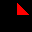

In [73]:
img, size, col, row, c = generate()
display(img)

In [74]:
preds = model.predict(np.asarray(img).reshape(-1, 32, 32, 3) / 255.0)

In [75]:
print(f"Size: {size} rounded prediction: {round(preds[0][0][0][0][0] * 32)}, raw {preds[0][0][0][0][0] * 32}")
print(f"Left: {col} rounded prediction: {round(preds[0][0][0][0][1] * 32)}, raw {preds[0][0][0][0][1] * 32}")
print(f"Top: {row} rounded prediction: {round(preds[0][0][0][0][2] * 32)}, raw {preds[0][0][0][0][2] * 32}")
print(f"Class: {classes[c]}  prediction: {classes[np.argmax(preds[1][0][0][0]) + 1]}")

Size: 12.0 rounded prediction: 12.0, raw 11.960250854492188
Left: 3.0 rounded prediction: 3.0, raw 3.38435959815979
Top: 17.0 rounded prediction: 17.0, raw 17.277193069458008
Class: Red Triangle  prediction: Red Triangle
